In [2]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [3]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%ls

__init__.py  datasets/  requirements.txt  utils/
data/        logs/      scripts/          wandb/


In [5]:
logs_path = './logs/results/cifar5m/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [6]:
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
96           no  0.1         True       False     0.001       False   
97           no  0.1         True       False     0.001       False   
98           no  0.1         True       False     0.001       False   
99           no  0.1         True       False     0.001       False   
100          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...   
0            0             5           False                True  ...  \
1            0             5           False                True  ...   
2            0             5           False                True  ...   
3            0             5           False                True  ...   
4            0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
96           0             5           False                True  ...   
97           0             5           False                True  ...   
98           0             5           False                True  ...   
99           0             5           False                True  ...   
100          0             5           False                True  ...   

     N_BLOCKS  gamma  final_val_acc_D  buffer_train_time final_train_acc_S   
0           1    1.0            78.18        1194.966549         90.303333  \
1           1    1.0            73.84         846.080246         75.695000   
2           1    1.0            73.84         844.939077         91.461667   
3           1    1.0            73.84         855.691574         76.206667   
4           1    1.0            73.84         865.116743         76.753333   
..        ...    ...              ...                ...               ...   
96          1    1.0            80.38         377.748105         82.595833   
97          1    1.0            80.38         380.091951         82.220833   
98          1    1.0            80.38         382.089314         92.312500   
99          1    1.0            80.38         357.452615         92.791667   
100         1    1.0            80.38         379.832249         93.008333   

     final_val_acc_S final_train_agreement  final_val_agreement   
0              82.04             83.103333                79.19  \
1              71.77             87.058333                84.44   
2              76.98             77.181667                72.47   
3              71.53             87.015000                84.57   
4              71.91             87.883333                85.09   
..               ...                   ...                  ...   
96             75.79             87.391667                79.60   
97             75.93             87.095833                79.90   
98             65.91             81.241667                66.33   
99             66.42             81.575000                66.70   
100            66.69             81.487500                67.87   

     final_val_function_distance  final_distance_teacher_student  
0                       0.224213                       99.827530  
1                       0.137418                       92.841354  
2                       0.301173                       92.903893  
3                       0.134699                       92.821602  
4                       0.132162                       92.759621  
..                           ...                             ...  
96                      0.214165                      135.08580

In [7]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student'],
      dtype='object')

In [8]:
buffer_sizes = list(res_df['buffer_size'].unique())
buffer_sizes

[120000, 60000, 600000, 1200000, 600, 1200, 6000, 12000, 24000]

In [9]:
teacher_val_accuracy = res_df['final_val_acc_D'][0]
#teacher_train_accuracy = 77.50
teacher_val_accuracy

78.18

In [10]:
res_df['buffer_size_p'] = res_df['buffer_size']/60000
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(teacher_val_accuracy)
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(teacher_val_accuracy)
working_df = res_df.loc[res_df['final_val_acc_D']==80.38]
working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
9            no  0.1         True       False     0.001       False  \
10           no  0.1         True       False     0.001       False   
11           no  0.1         True       False     0.001       False   
12           no  0.1         True       False     0.001       False   
13           no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
96           no  0.1         True       False     0.001       False   
97           no  0.1         True       False     0.001       False   
98           no  0.1         True       False     0.001       False   
99           no  0.1         True       False     0.001       False   
100          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...   
9            0             5           False                True  ...  \
10           0             5           False                True  ...   
11           0             5           False                True  ...   
12           0             5           False                True  ...   
13           0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
96           0             5           False                True  ...   
97           0             5           False                True  ...   
98           0             5           False                True  ...   
99           0             5           False                True  ...   
100          0             5           False                True  ...   

     final_train_acc_S  final_val_acc_S  final_train_agreement   
9            83.318333            79.44              88.063333  \
10           83.618333            79.54              88.260000   
11           83.125000            79.38              88.188333   
12           91.676667            77.14              83.101667   
13           91.545000            76.33              83.056667   
..                 ...              ...                    ...   
96           82.595833            75.79              87.391667   
97           82.220833            75.93              87.095833   
98           92.312500            65.91              81.241667   
99           92.791667            66.42              81.575000   
100          93.008333            66.69              81.487500   

     final_val_agreement final_val_function_distance   
9                  84.41                    0.167789  \
10                 84.10                    0.167323   
11                 84.36                    0.165912   
12                 76.05                    0.256830   
13                 76.36                    0.257118   
..                   ...                         ...   
96                 79.60                    0.214165   
97                 79.90                    0.211925   
98                 66.33                    0.341851   
99                 66.70                    0.339940   
100                67.87                    0.332657   

     final_distance_teacher_student buffer_size_p  generalization_gap   
9                         92.067696           1.0           -3.878333  \
10                        92.183929           1.0           -4.078333   
11                        92.082825           1.0           -3.745000   
12                        89.643623           1.0          -14.536667   
13                        89.576874           1.0          -15.215000   
..                              ...           ...                 ...   
96                       135.085800           0.4           -6.805833   
97                       134.979660           0.4           -6.290833   
98                       133.546890           0.4          -26.402500   
99                       133.632889           0.4          -26.371667   
100  

In [11]:
buffer_sizes_p = sorted(working_df['buffer_size_p'].unique())
buffer_sizes_p

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0, 20.0]

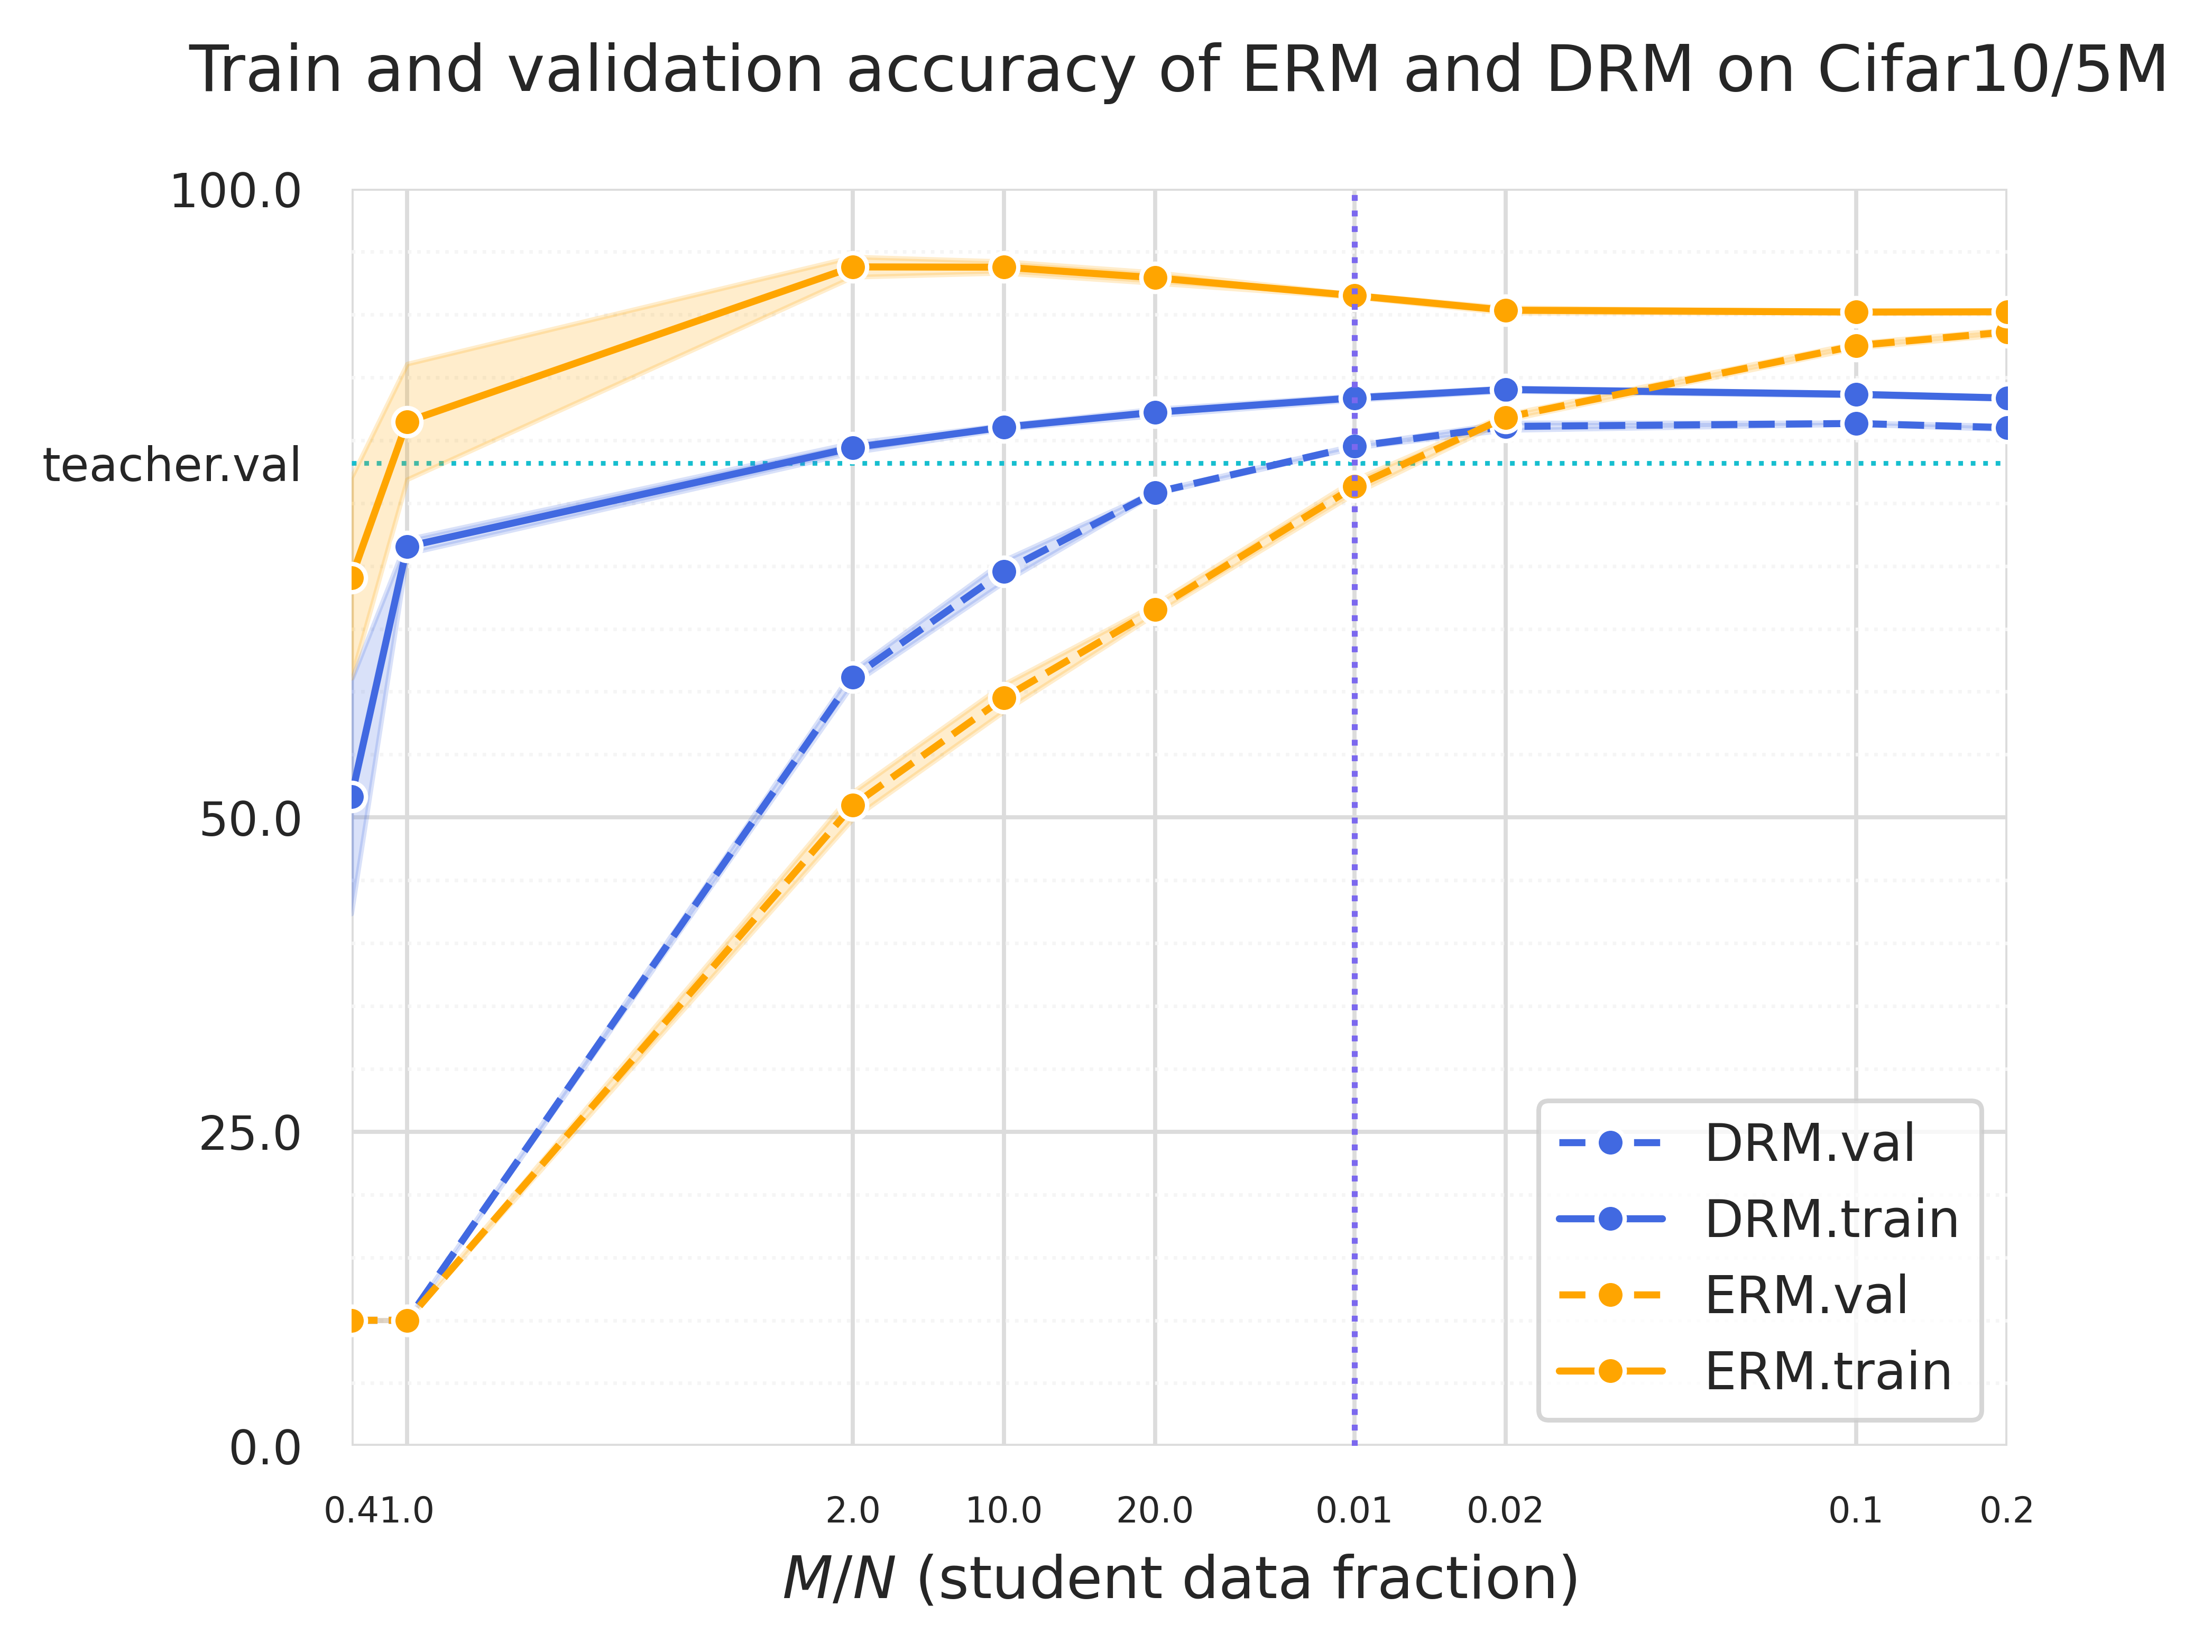

In [12]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in buffer_sizes_p], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val','DRM.train',
                  'ERM.val','ERM.train',
                  'teacher.val','teacher.train'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:cyan')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


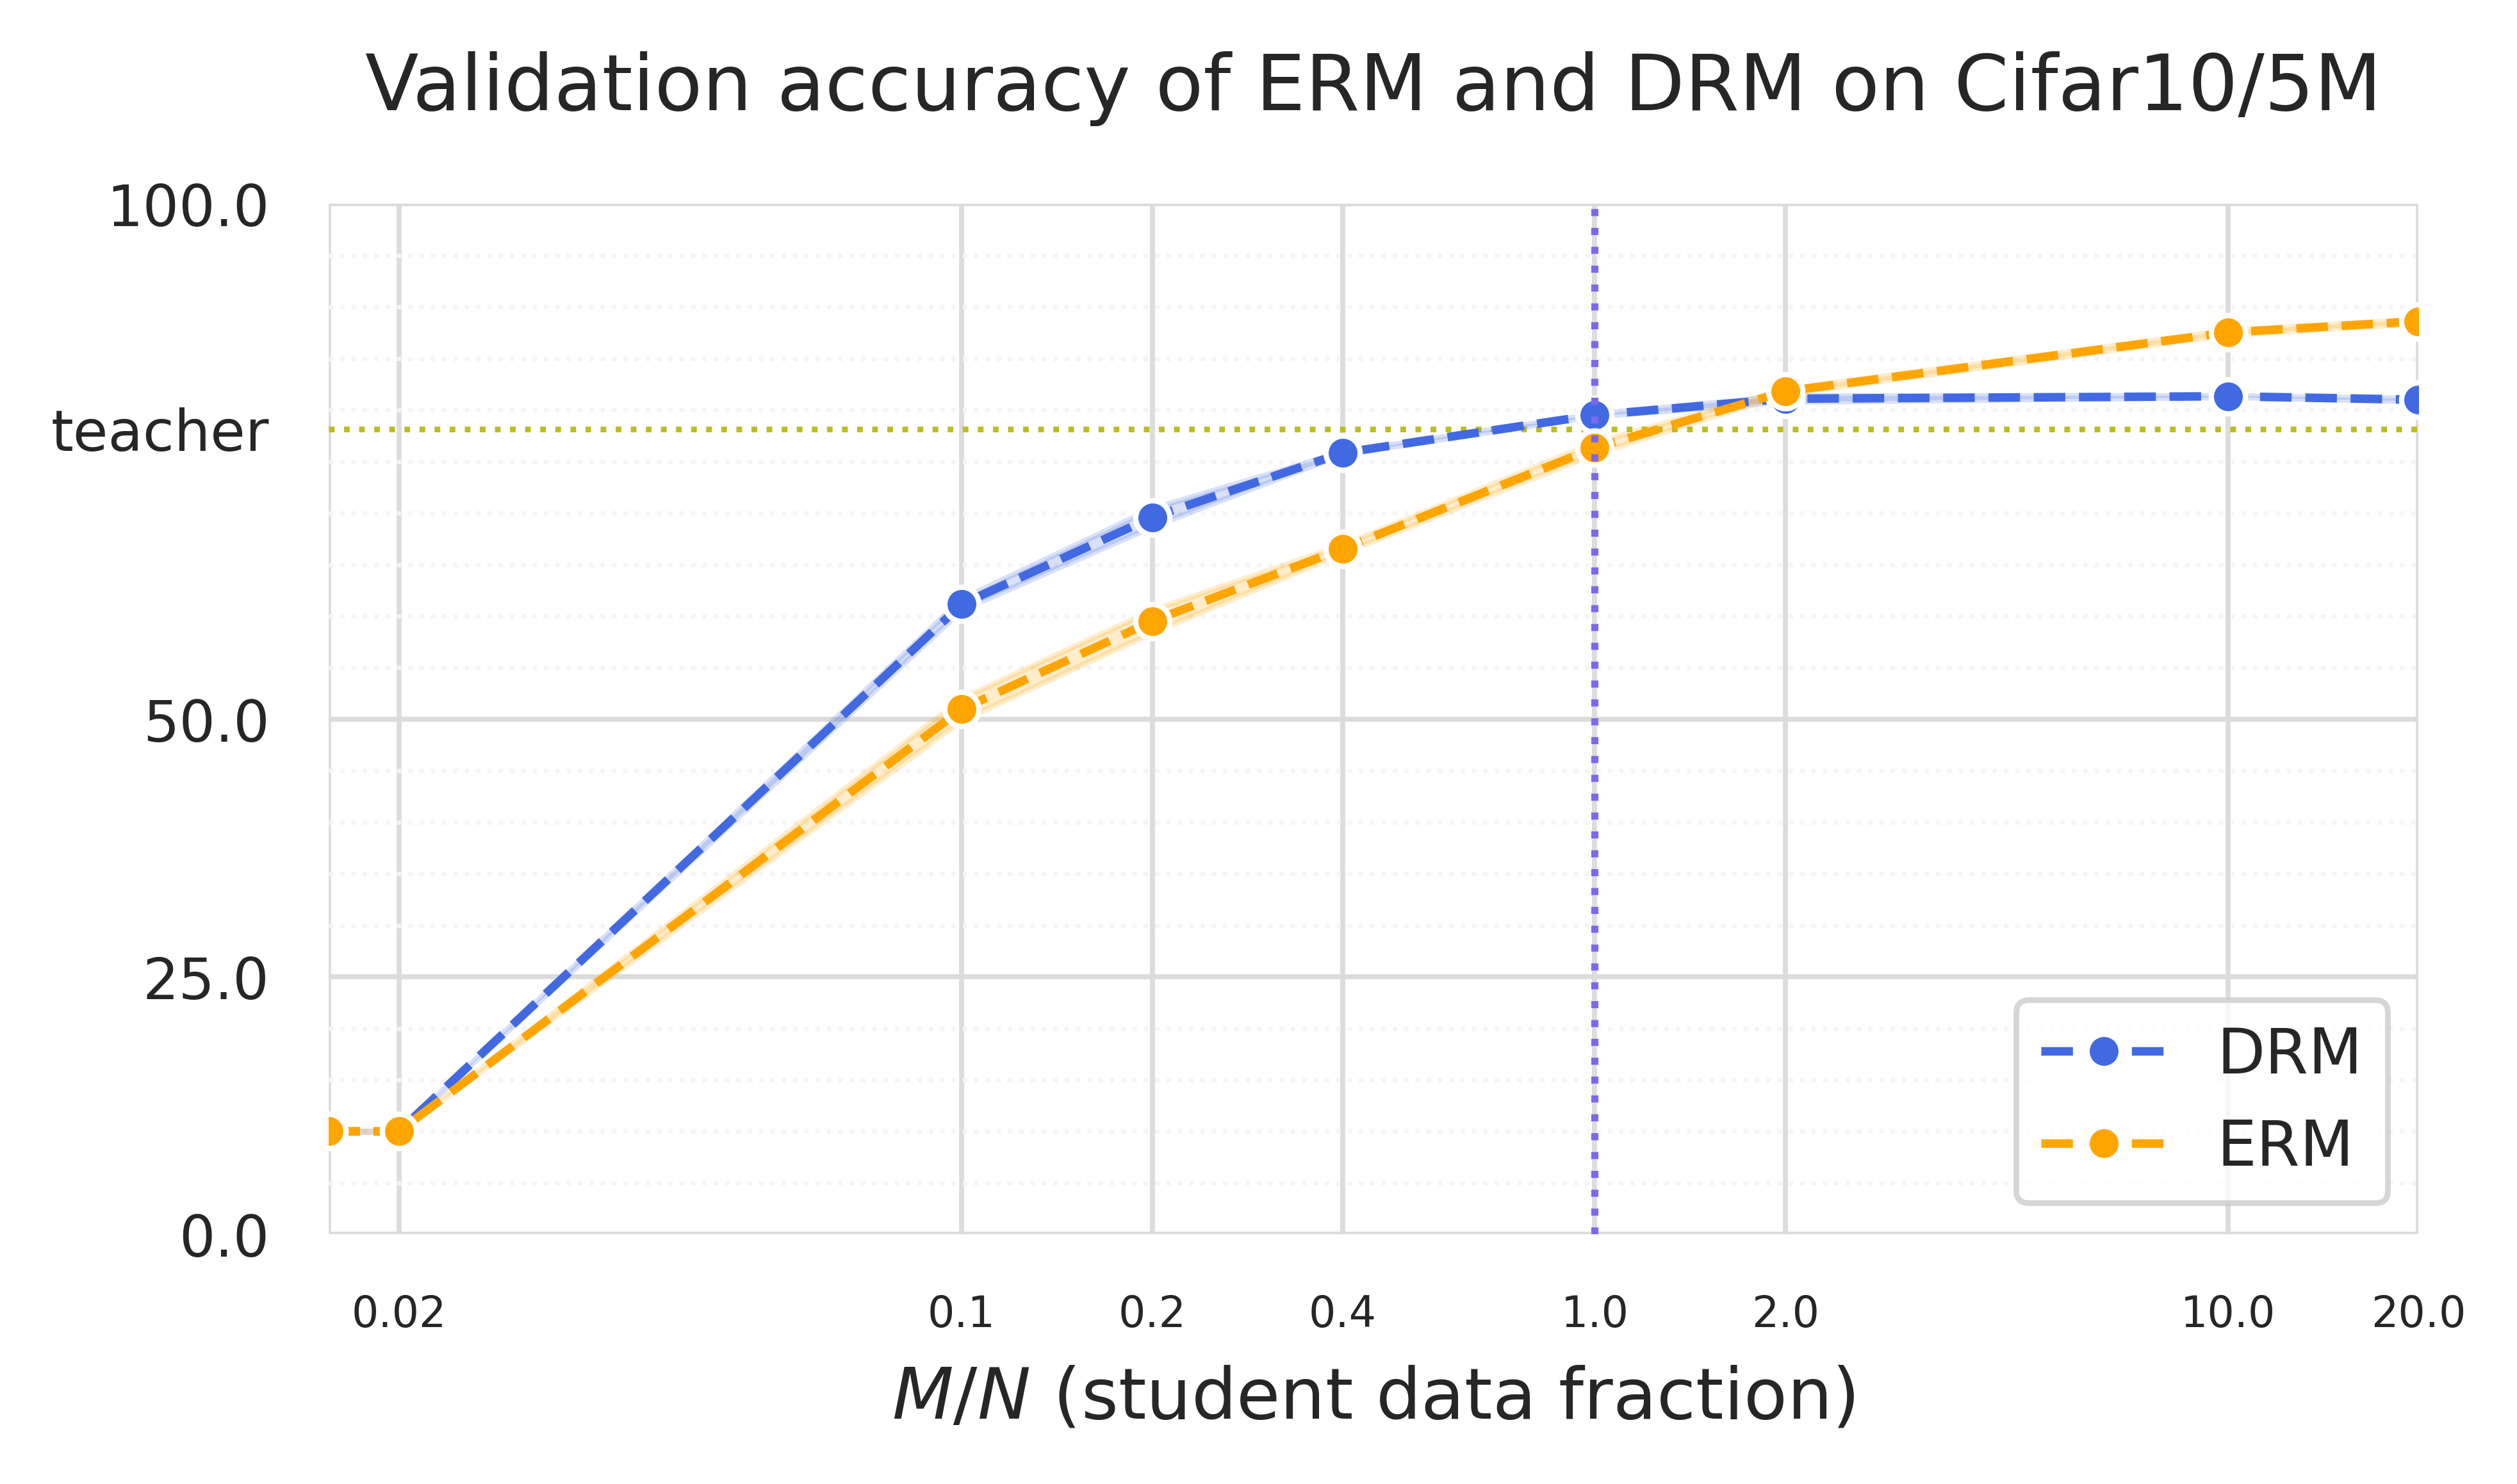

In [14]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


In [54]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="DRM error")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="ERM error")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Generalisation gap of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM error',
                  'ERM error'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[6]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


## Covariance exploration

In [14]:
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar

In [15]:
DEVICE=[1]
device = get_device(DEVICE)

In [16]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "/chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          if filename=='checkpoint_90.pth.tar' and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [17]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [18]:
from torch.utils.data import ConcatDataset

In [19]:
all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(
        all_data, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

In [22]:
# initialising the model
weights = None
model = resnet50(weights=weights)

chkpt_name = f"checkpoint_90.pth.tar" #sidak's checkpoint
checkpoint = load_checkpoint(best=False, filename=chkpt_name, distributed=False) #TODO: switch best off
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
best_acc1 = checkpoint['best_acc1']

Loading existing checkpoint ./logs//chkpts/imagenet/resnet50/checkpoint_90.pth.tar


In [20]:
weights = None
model = resnet50(weights=weights)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
'layer1.0.conv'.split('.')

['layer1', '0', 'conv']

In [24]:
tot = 0
for n,m in model.named_modules():
    #if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
    if len(list(m.children()))==0: print(f"Module {n}")

    #print(sum([p.numel() for p in m.parameters()]))
    tot +=1
print(tot)

Module conv1
Module bn1
Module relu
Module maxpool
Module layer1.0.conv1
Module layer1.0.bn1
Module layer1.0.conv2
Module layer1.0.bn2
Module layer1.0.conv3
Module layer1.0.bn3
Module layer1.0.relu
Module layer1.0.downsample.0
Module layer1.0.downsample.1
Module layer1.1.conv1
Module layer1.1.bn1
Module layer1.1.conv2
Module layer1.1.bn2
Module layer1.1.conv3
Module layer1.1.bn3
Module layer1.1.relu
Module layer1.2.conv1
Module layer1.2.bn1
Module layer1.2.conv2
Module layer1.2.bn2
Module layer1.2.conv3
Module layer1.2.bn3
Module layer1.2.relu
Module layer2.0.conv1
Module layer2.0.bn1
Module layer2.0.conv2
Module layer2.0.bn2
Module layer2.0.conv3
Module layer2.0.bn3
Module layer2.0.relu
Module layer2.0.downsample.0
Module layer2.0.downsample.1
Module layer2.1.conv1
Module layer2.1.bn1
Module layer2.1.conv2
Module layer2.1.bn2
Module layer2.1.conv3
Module layer2.1.bn3
Module layer2.1.relu
Module layer2.2.conv1
Module layer2.2.bn1
Module layer2.2.conv2
Module layer2.2.bn2
Module layer2.

In [12]:
x, y = all_data_loader.__iter__().__next__()
x = x.to(device)
for n,m in model.named_modules():
    print(f"Module {n}")
    with torch.no_grad(): 
        if n=='fc':x=torch.flatten(x, 1)
        out = m(x)
    print("IN: ",x.shape)
    print("OUT: ", out.shape)
    print(sum(p.numel() for p in m.parameters()))
    x = out

Module conv1
IN:  torch.Size([64, 3, 224, 224])
OUT:  torch.Size([64, 64, 112, 112])
9408
Module bn1
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 112, 112])
128
Module relu
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 112, 112])
0
Module maxpool
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 56, 56])
0
Module layer1
IN:  torch.Size([64, 64, 56, 56])
OUT:  torch.Size([64, 256, 56, 56])
215808
Module layer2
IN:  torch.Size([64, 256, 56, 56])
OUT:  torch.Size([64, 512, 28, 28])
1219584
Module layer3
IN:  torch.Size([64, 512, 28, 28])
OUT:  torch.Size([64, 1024, 14, 14])
7098368
Module layer4
IN:  torch.Size([64, 1024, 14, 14])
OUT:  torch.Size([64, 2048, 7, 7])
14964736
Module avgpool
IN:  torch.Size([64, 2048, 7, 7])
OUT:  torch.Size([64, 2048, 1, 1])
0
Module fc
IN:  torch.Size([64, 2048])
OUT:  torch.Size([64, 1000])
2049000


In [3]:
a = torch.randn(4, 4)
a.requires_grad = True 
b = a * 3 
b 
#idx = torch.argsort(a, dim=1, descending=True)
#a

tensor([[ 0.0358,  7.5796, -2.1851, -3.1684],
        [-5.1815,  0.3690,  2.7026, -3.8091],
        [ 1.3273, -3.1359,  2.7200, -5.4398],
        [ 1.6102,  3.1359,  2.4219, -2.0800]], grad_fn=<MulBackward0>)

In [4]:
A = torch.rand(10, 4)
_, B = torch.sort(A, descending=True)

In [23]:
B = torch.ones_like(A)
B = torch.multinomial(B,2)
B

tensor([[1, 0],
        [1, 0],
        [3, 1],
        [1, 3],
        [0, 3],
        [3, 1],
        [2, 1],
        [2, 0],
        [1, 0],
        [2, 0]])

In [18]:
torch.randperm(4)

tensor([3, 0, 1, 2])

In [22]:
A

tensor([[0.2863, 0.0912, 0.3332, 0.8146],
        [0.4785, 0.8325, 0.1543, 0.3082],
        [0.5242, 0.7830, 0.2470, 0.5029],
        [0.9958, 0.3832, 0.1513, 0.8709],
        [0.9892, 0.0668, 0.5280, 0.5143],
        [0.8096, 0.9074, 0.4371, 0.7919],
        [0.8517, 0.9794, 0.0613, 0.7241],
        [0.4687, 0.0100, 0.2444, 0.0021],
        [0.0098, 0.6292, 0.7003, 0.6617],
        [0.8010, 0.9793, 0.7033, 0.7052]])

In [21]:
torch.gather(A, 1, B)

tensor([[0.0912, 0.8146],
        [0.3082, 0.8325],
        [0.5242, 0.2470],
        [0.3832, 0.9958],
        [0.9892, 0.5280],
        [0.9074, 0.8096],
        [0.9794, 0.8517],
        [0.0100, 0.2444],
        [0.6292, 0.6617],
        [0.7052, 0.9793]])

In [50]:
B_changed

tensor([[[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]],

        [[1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[2, 2, 2, 2],
         [3, 3, 3, 3],
         [0, 0, 0, 0],
         [1, 1, 1, 1]],

        [[3, 3, 3, 3],
         [1, 1, 1, 1],
         [0, 0, 0, 0],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[1, 1, 1, 1],
         [3, 3, 3, 3],
         [2, 2, 2, 2],
         [0, 0, 0, 0]],

        [[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]]])

In [47]:
B_changed = torch.tile(B[..., None], (1,A.shape[1]))
A_new = torch.gather(a, dim = 1, index = B_changed)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [24]:
torch.take(a, idx[:,:2])

tensor([[ 0.4074, -0.0143],
        [ 0.4074, -0.3782],
        [-0.0143, -0.3782],
        [ 0.4074, -0.0143]])

#### First, we register train accuracy

In [12]:
train_loader = DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
#TODO: add estimate of the average teacher logits magnitude
progress_bar = ProgressBar(verbose=True)
correct, total = 0.0, 0.0
average_magnitude = 0
for i,data in enumerate(train_loader):
        #if i==3: break
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #average_magnitude += (outputs.max(dim=1)[0]-outputs.min(dim=1)[0]).sum(dim=0)
            average_non_max = (outputs.sum(dim=1) - outputs.max(dim=1)[0])/999 # average over the non-max outputs
            average_magnitude += (outputs.max(dim=1)[0] - average_non_max).sum(dim=0)
            _, pred = torch.max(outputs.data, 1)
            correct += torch.sum(pred == labels).item()
            total += labels.shape[0]
        progress_bar.prog(i, len(train_loader), (average_magnitude/total), 'D', (correct / total) * 100)     
acc=(correct / total) * 100
average_magnitude /= total

[ 08-10 | 12:18 ] Task D | epoch 14.51735782623291: |██████████████████████████████████████████████████| 2.87 ep/h | loss: 77.55202874 ||

In [ ]:
# max - min average = 19.93
# max - avg(rest) = 14.52

#### Now we collect all the labels and all the outputs

In [ ]:
# running estimate of the outer products and mean
Y2 = 0; Ymu = 0; t2 = 0; tmu = 0; total=0
C = 1000
progress_bar = ProgressBar(verbose=True)

for i, data in enumerate(all_data_loader):
    #if i==10: break # for testing
    with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=C).view(-1,C,1).to(torch.float64)
            outputs = model(inputs)
            outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
            total += labels.shape[0]
            Y2 += torch.matmul(labels,labels.permute(0,2,1)).sum(dim=0)
            Ymu += labels.sum(dim=0)
            t2 += torch.matmul(outputs,outputs.permute(0,2,1)).to(torch.float64).sum(dim=0)
            tmu += outputs.sum(dim=0)
    progress_bar.prog(i, len(all_data_loader), -1, 'D', i/(len(all_data_loader)))  
    
# summing over the batch dimension 
Ymu = Ymu/total
tmu = tmu/total
# subtracting the mean and averaging
SigmaY = (Y2 - torch.matmul(Ymu.view(C,1),Ymu.view(1,C)))/((total-1))
SigmaT = (t2 - torch.matmul(tmu.view(C,1),tmu.view(1,C)))/((total-1))

/tmp/ipykernel_2101918/2421696559.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
[ 08-01 | 17:58 ] Task D | epoch -1: |██████████████████████████████████████████████████| 1.62 ep/h | loss: 0.99995192 |

In [ ]:
t2.shape

torch.Size([1000, 1000])

In [ ]:
SigmaY = SigmaY.detach().cpu().numpy()
SigmaT = SigmaT.detach().cpu().numpy()

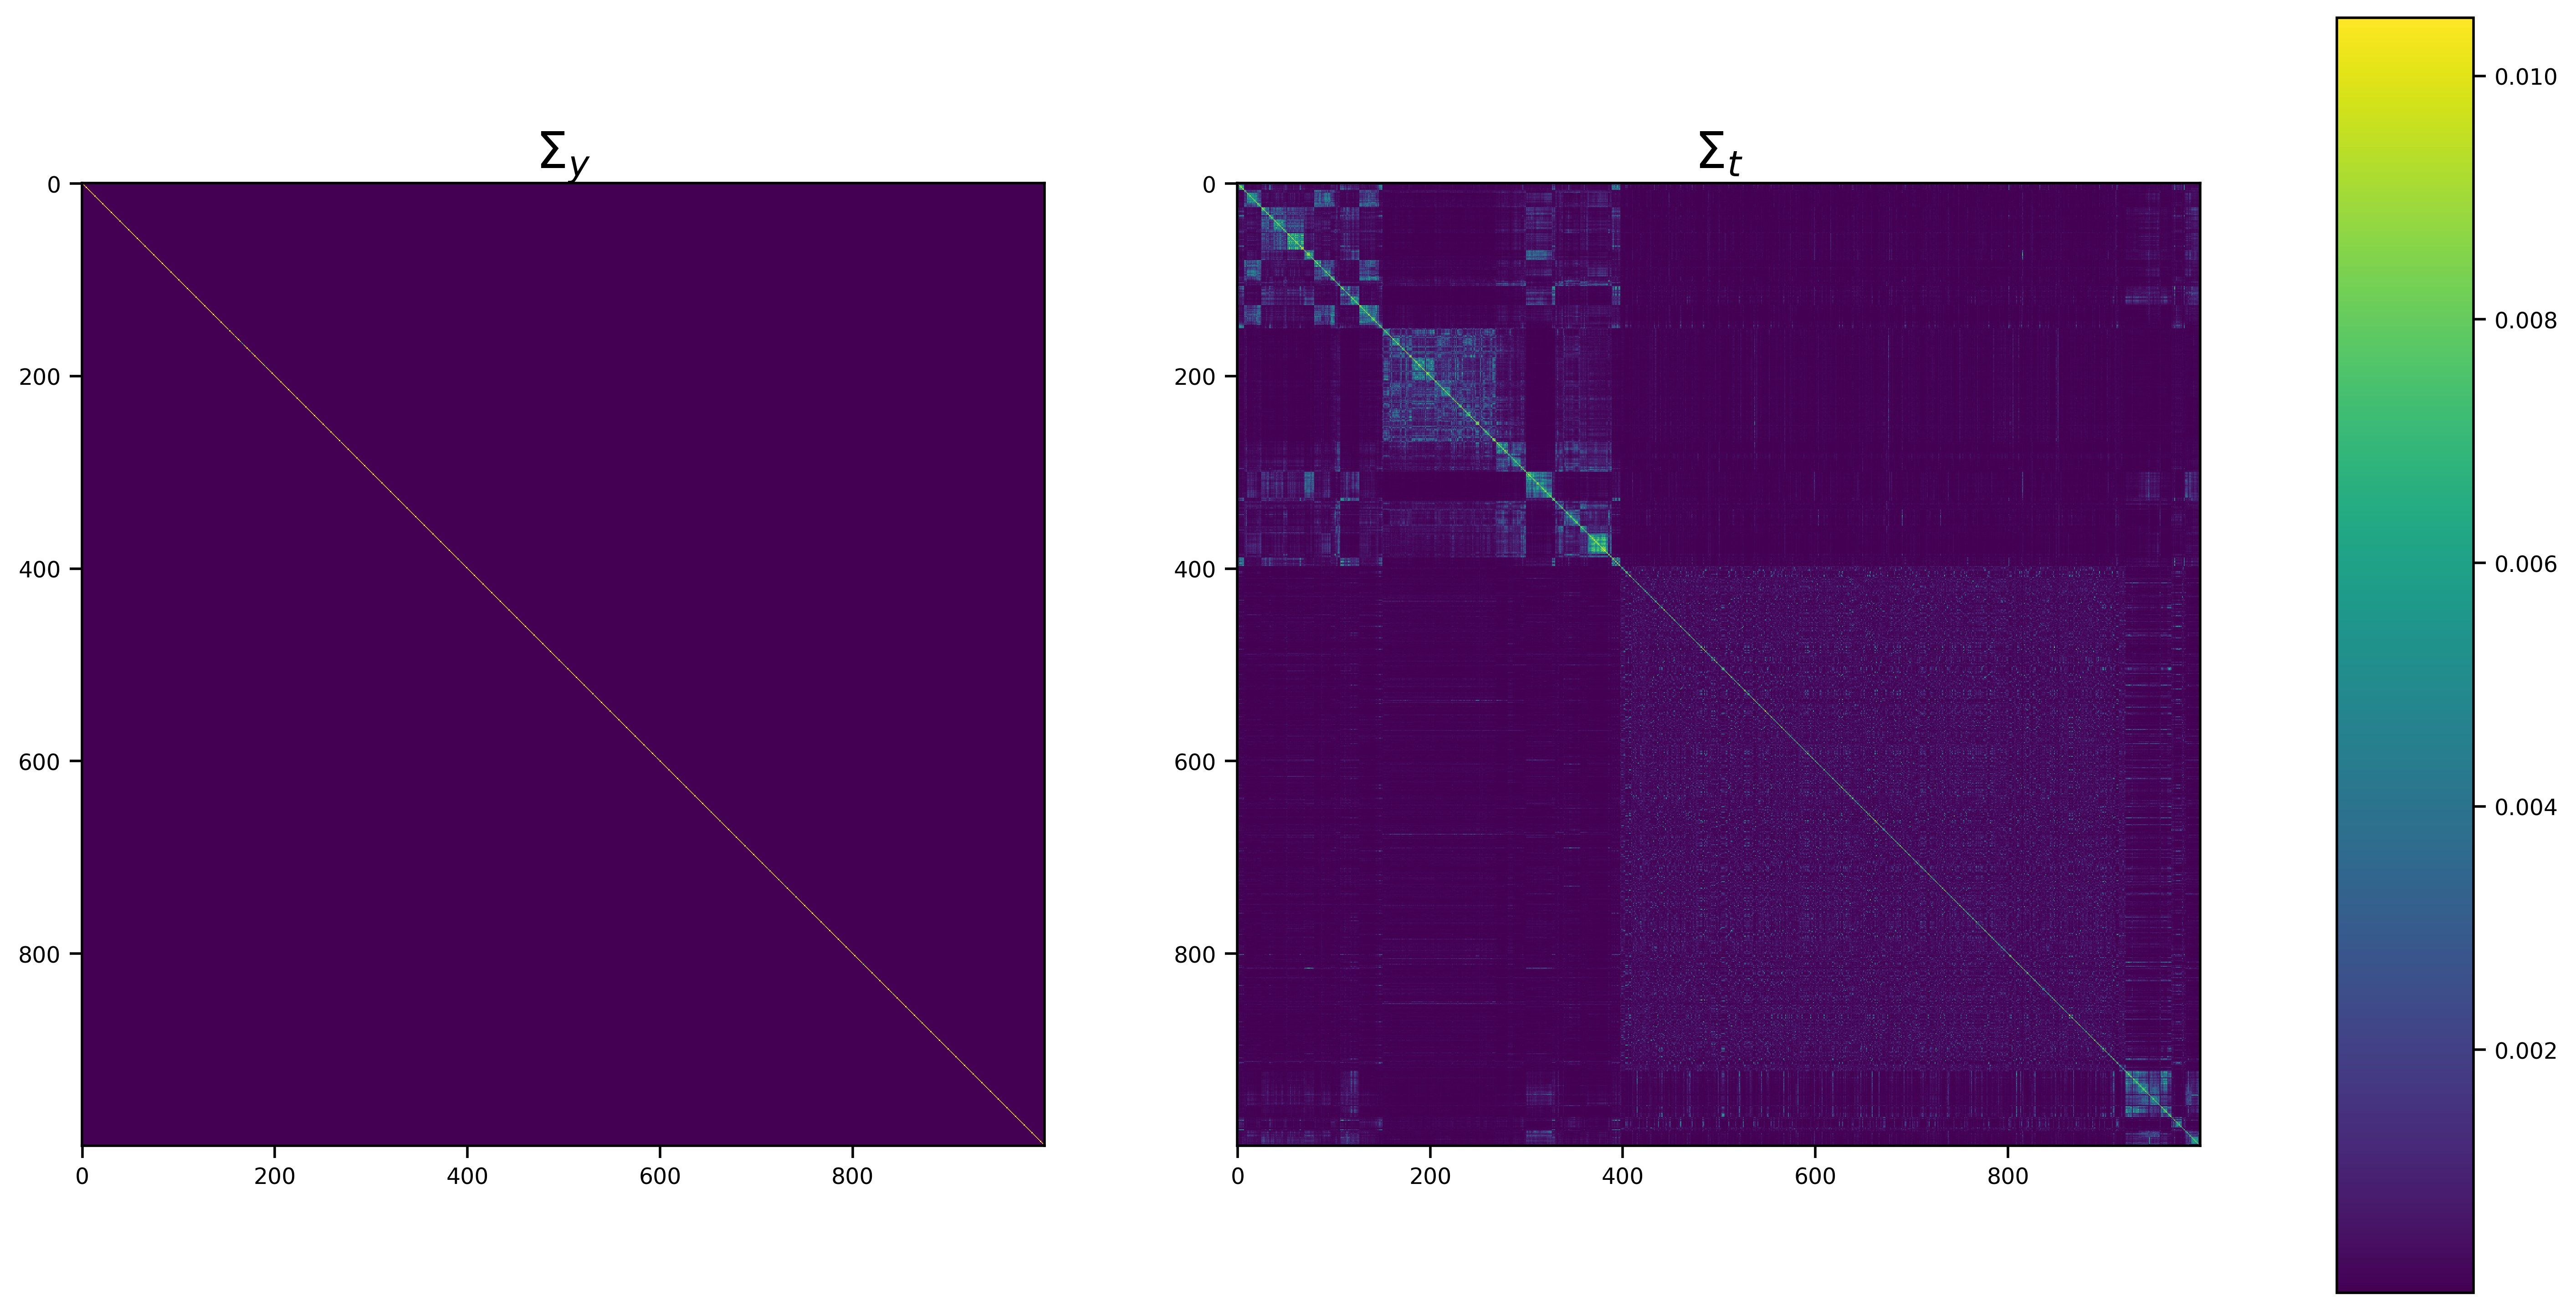

In [ ]:
#M = SigmaT.detach().cpu().numpy()
#assert (M == M.T).sum() == 1000**2
fig, ax = plt.subplots(1,2, figsize=(15,10), dpi=400)

mat = ax[0].matshow(SigmaY)
ax[0].set_title(r'$\Sigma_y$',fontsize=20)
ax[0].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[0].tick_params(axis='y', colors='black', bottom=True, top=False)

mat = ax[1].matshow(SigmaT)
ax[1].set_title(r'$\Sigma_t$',fontsize=20)
ax[1].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[1].tick_params(axis='y', colors='black', bottom=True, top=False)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)
#fig.colorbar(mat, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.7)

In [57]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
np.save(path + "SigmaY.npy", SigmaY)
np.save(path + "SigmaT.npy", SigmaT)

In [22]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
with open(path+ "SigmaY.npy", 'rb') as f:
    SigmaY = np.load(f)
with open(path+ "SigmaT.npy", 'rb') as f:
    SigmaT = np.load(f)

Now we perform an eigenvalue analysis

Text(0.5, 1.0, 'Distribution')

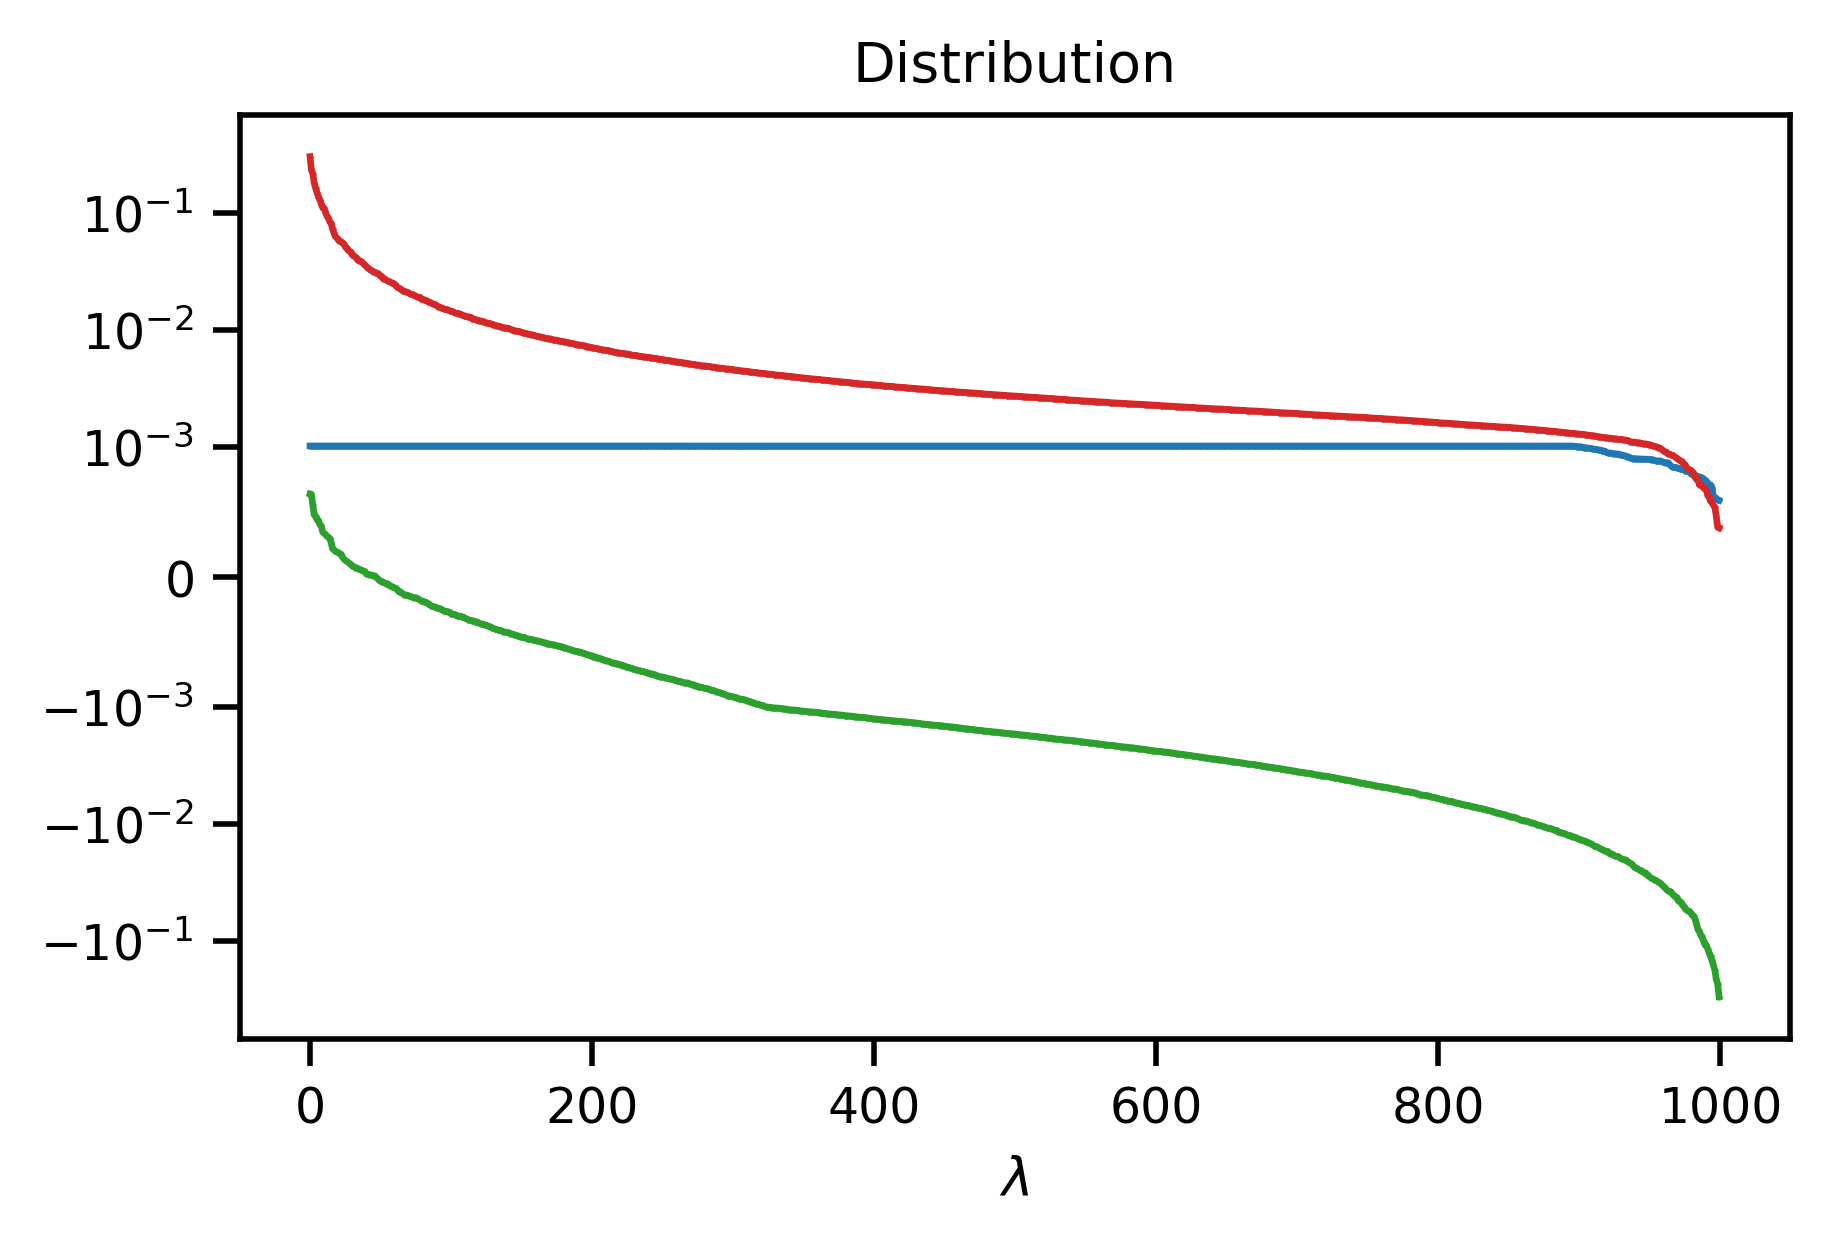

In [23]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

L, V = np.linalg.eigh(SigmaY)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:red')
x = list(range(L.shape[0]))
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:blue', ms=0.5)
L, V = np.linalg.eigh(SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:red', ms=0.5)
L, V = np.linalg.eigh(SigmaY-SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:green', ms=0.5)
#ax.set_xscale('symlog', linthresh=0.001)
ax.set_yscale('symlog', linthresh=10e-4)
#ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Distribution', fontsize=10)


In [25]:
L, V = np.linalg.eigh(SigmaY-SigmaT)

In [26]:
L.sum()

-6.910937427854297

Loss variance inequality results

In [6]:
logs_path = './logs/results/imagenet/resnet50/LVI.txt'
LVI_results = []
with open(logs_path) as f:
    while line := f.readline():
        LVI_results.append(json.loads(line))

In [7]:
LVI_df = pd.DataFrame(LVI_results)
LVI_df

deltaV    deltaM         ceV
0   0.054165  0.001005  119.317673
1   0.048214 -0.000162   87.803452
2   0.056888 -0.000778   97.328506
3   0.050351 -0.000491   81.199448
4   0.052822 -0.001234   95.889977
..       ...       ...         ...
95  0.053986  0.000037   93.294701
96  0.055877 -0.000317   95.649750
97  0.054854 -0.001404   99.921059
98  0.056321  0.000598  123.797859
99  0.051088 -0.000733   78.876572

[100 rows x 3 columns]

In [8]:
LVI_df['Nmax'] = (2*LVI_df['ceV'] - LVI_df['deltaV'])/(LVI_df['deltaM']**2)
LVI_df

deltaV    deltaM         ceV          Nmax
0   0.054165  0.001005  119.317673  2.363297e+08
1   0.048214 -0.000162   87.803452  6.704057e+09
2   0.056888 -0.000778   97.328506  3.213914e+08
3   0.050351 -0.000491   81.199448  6.736215e+08
4   0.052822 -0.001234   95.889977  1.260082e+08
..       ...       ...         ...           ...
95  0.053986  0.000037   93.294701  1.375075e+11
96  0.055877 -0.000317   95.649750  1.900463e+09
97  0.054854 -0.001404   99.921059  1.013461e+08
98  0.056321  0.000598  123.797859  6.932818e+08
99  0.051088 -0.000733   78.876572  2.933621e+08

[100 rows x 4 columns]

In [39]:
def abline(slope, intercept, x_vals):
    """Return a line from slope and intercept, taking input values in a logspace"""
    y_vals = intercept + slope * x_vals
    return y_vals

In [16]:
LVI_df.loc[0, 'deltaM']

0.0010047522373497486

In [55]:
ys = []
x = np.logspace(2, 14, num=50)
for i in range(len(LVI_df)):
    slope = LVI_df.loc[i, 'deltaM']**2
    intercept = LVI_df.loc[i, 'deltaV'] - 2*LVI_df.loc[i, 'ceV']
    y = abline(slope, intercept, x)
    ys.append(y)

In [143]:
M = 1.2*1e6

In [158]:
np.asarray(ys).shape

(100, 50)

In [175]:
df

variable         value
0            0 -2.385811e+02
1            0 -1.755587e+02
2            0 -1.946001e+02
3            0 -1.623485e+02
4            0 -1.917270e+02
...        ...           ...
4995        49  1.354682e+05
4996        49  1.006281e+07
4997        49  1.971334e+08
4998        49  3.570521e+07
4999        49  5.375663e+07

[5000 rows x 2 columns]

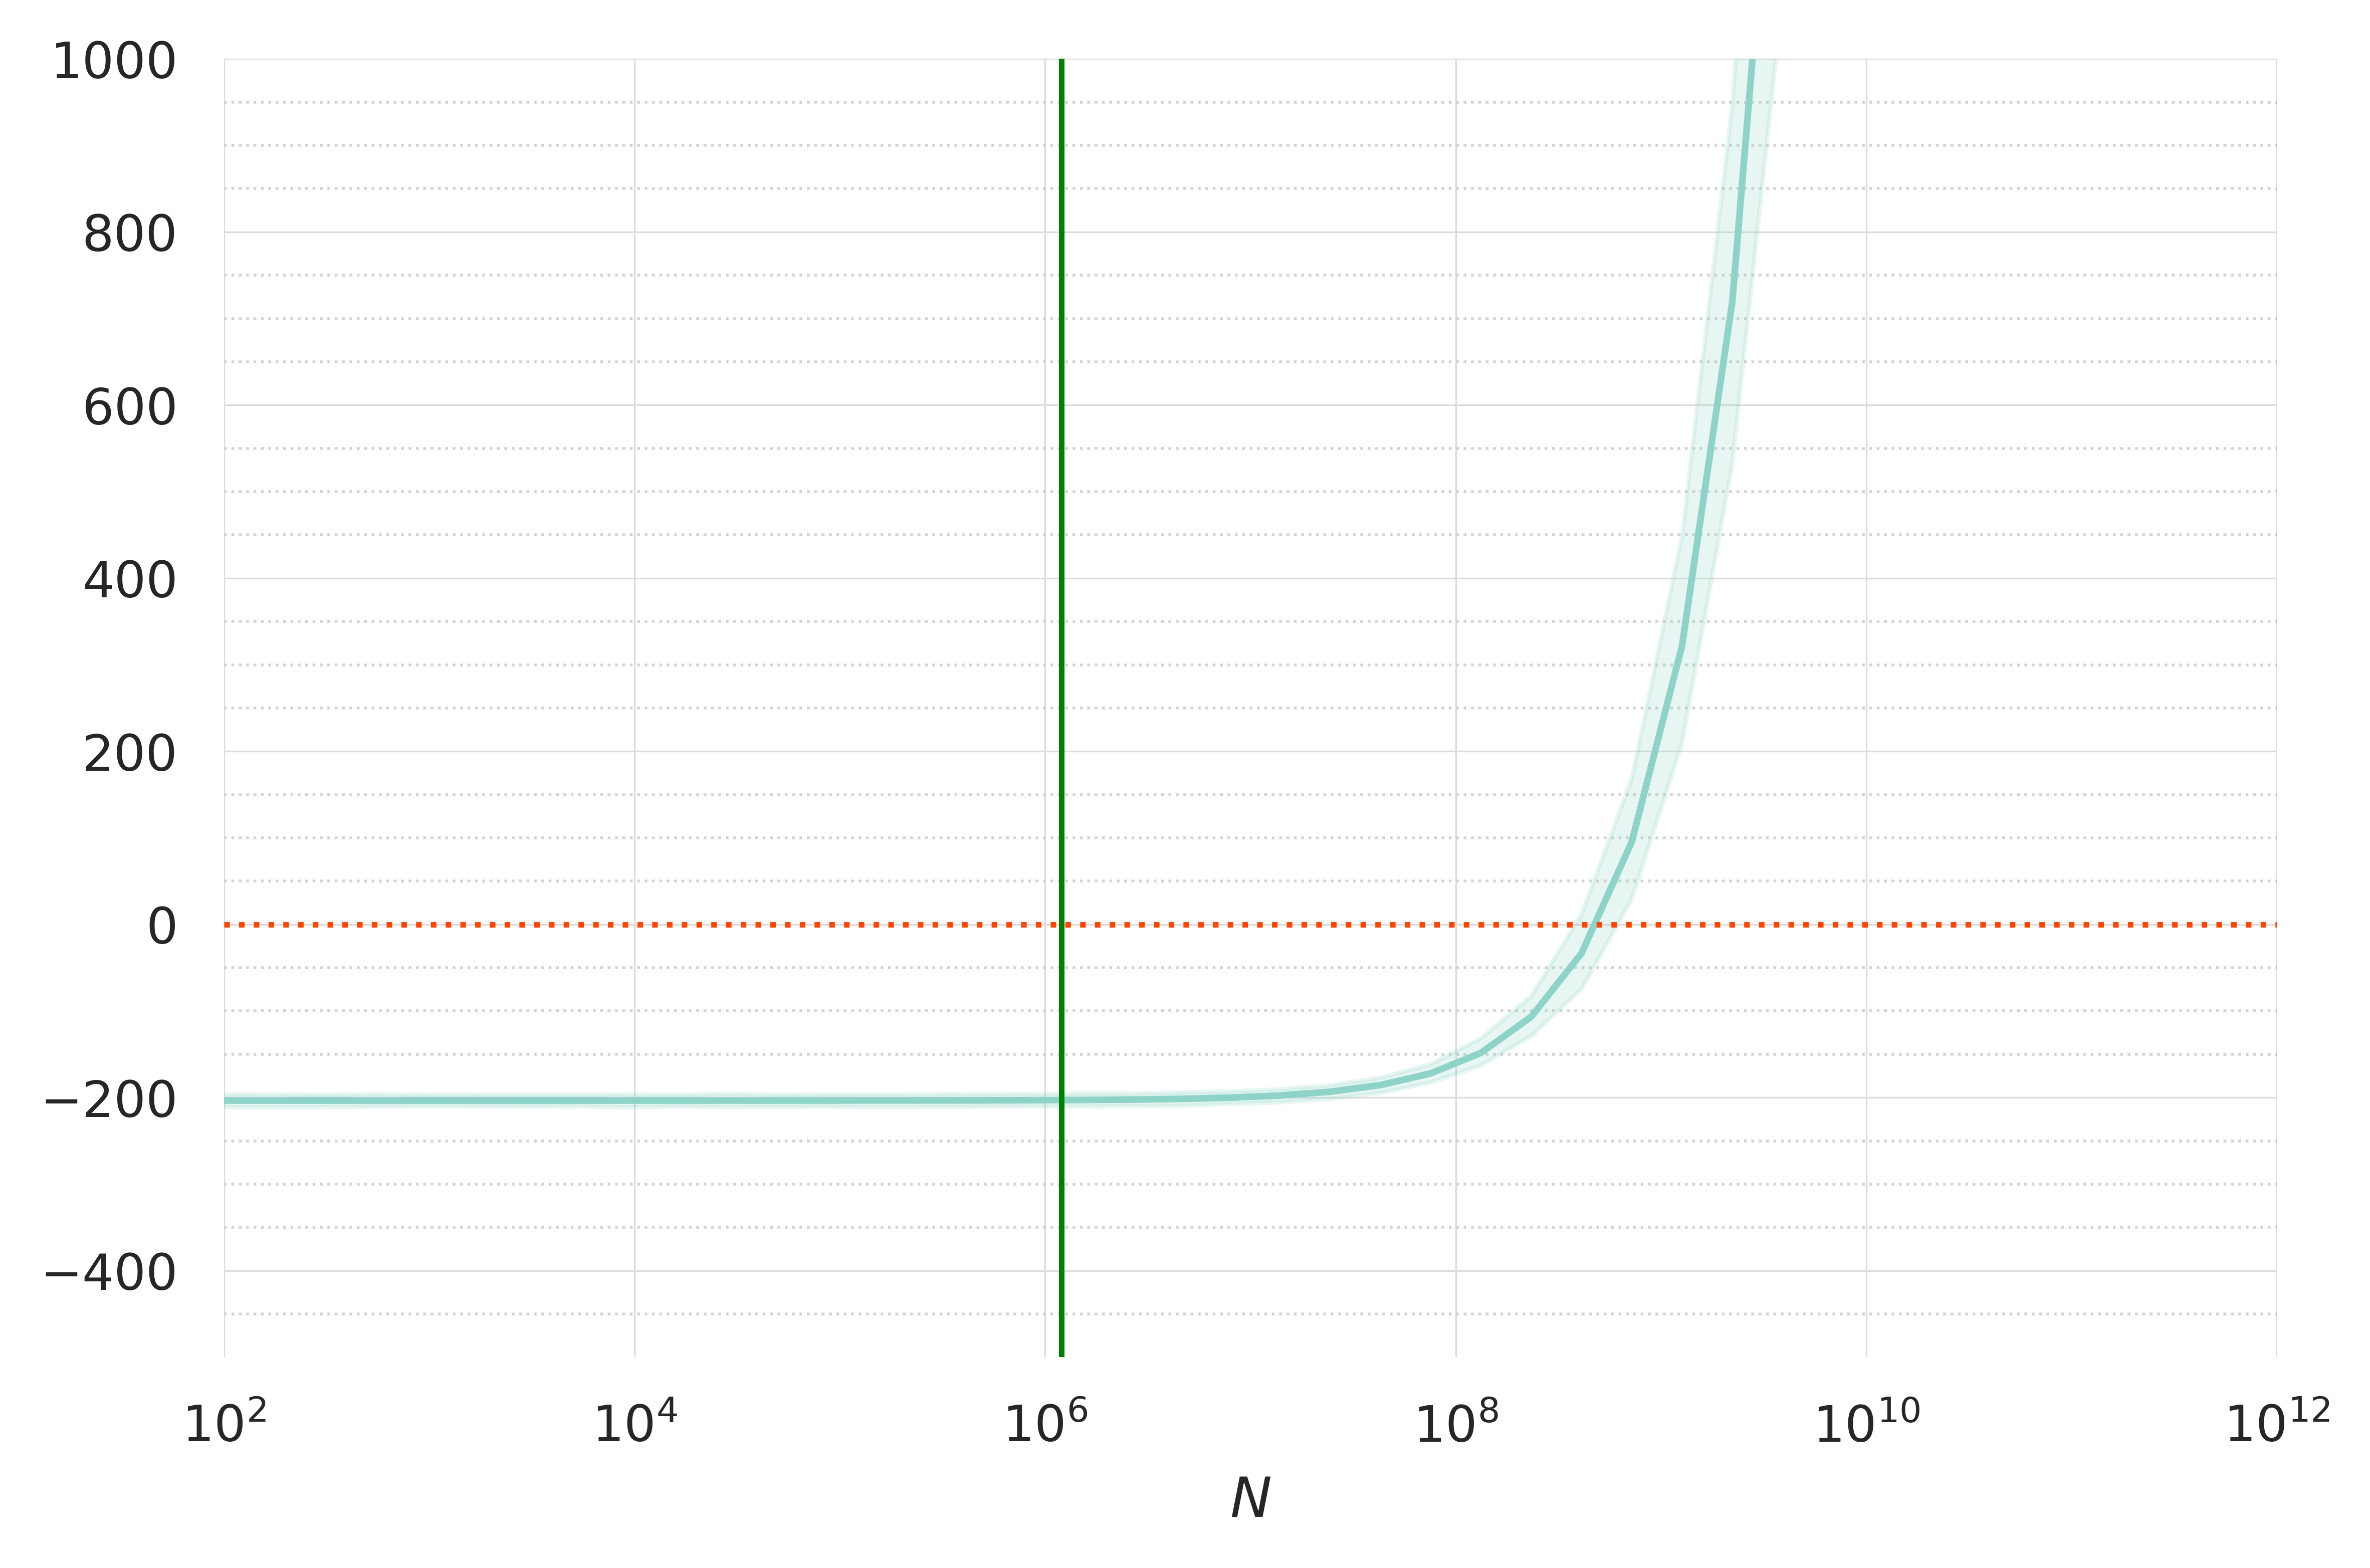

In [194]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    #plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = 'coolwarm'
    
    segs = [np.column_stack([x, y]) for y in ys]
    # line_segments = LineCollection(segs, array=x,
    #                            #linewidths=(0.5, 1, 1.5, 2),
    #                            #cmap=plt.cm.get_cmap(colors),
    #                            colors='skyblue',
    #                            linestyles='solid')
    # ax.add_collection(line_segments)
    #fig.colorbar(line_segments)
    #plt.sci(line_segments)
    df = pd.DataFrame(np.asarray(ys)).melt()
    df['x'] = np.repeat(x, repeats=100)
    sns.lineplot(x="x", y="value", data=df)
    ax.set_xscale('log')
    #ax.set_xticks(x)
    #
    #ax.set_xticklabels([ f'{l}' for l in x], fontsize=8)
    #ax.tick_params(axis='x',  rotation=45)


    #ax.set_yscale('symlog', linthresh=100)
    ax.set_xlim([100,1e12])
    ax.set_ylim([-500,1e3])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_title(f"", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$N$', fontsize=10, y=+5)

    ax.axhline(0, color="orangered", linewidth=1.0, linestyle=':')
    ax.axvline(M, color="green", linewidth=1.0, linestyle='-')


    # AESTHETICS control 
    #ax.set_facecolor('midnightblue')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.3)
    ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    
    plt.tight_layout()
    plt.show()
